In [165]:
import pandas as pd
import numpy as np
import pylab as pl

from random import randrange
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

from sklearn.metrics import confusion_matrix, classification_report

2023-12-03 09:13:20.319217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data V1

## Data Training 

In [82]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
df = pd.read_csv("/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/data/train_data_cl.csv", header=None, names=list(range(13)))
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NaN
1,1,0,3,Braund,Mr. Owen Harris,male,22,1,0,A/5 21171,7.25,NaN,S
2,2,1,1,Cumings,Mrs. John Bradley (Florence Briggs Thayer),female,38,1,0,PC 17599,712.833,C85,C
3,3,1,3,Heikkinen,Miss. Laina,female,26,0,0,STON/O2. 3101282,7.925,NaN,S
4,4,1,1,Futrelle,Mrs. Jacques Heath (Lily May Peel),female,35,1,0,113803,53.1,C123,S


### Data Preprocessing

In [83]:
### Benerin column
col_name = df.iloc[0,:12].values
col_name = np.insert(col_name, 4, "FirstName")

df.columns = col_name
df = df.drop(0).reset_index(drop=True)

df.head()
### Merge Name dan FirstName
df["Name"] = df["FirstName"] + " " + df["Name"]
df = df.drop("FirstName", axis=1)
df
### Perbaikan data yang tidak sesuai

print(df['Sex'].unique().tolist())
true_sex_val = ['male', 'female']
count = 0
for val in df["Sex"].values:
    if val not in true_sex_val:
        df.loc[count, 'Sex'] = np.random.choice(true_sex_val)
    count += 1
print(df['Sex'].unique().tolist())

count = 0
for val in df['Fare'].values:
    try:
        float(val)
    except ValueError:
        df.loc[count, 'Fare'] = 0
    count += 1

count = 0
for val in df['Parch'].values:
    if len(val) > 1:
        df.loc[count, 'Parch'] = 0
    count += 1

['male', 'female', '15', '27', '9', '36.5', '16', '40', '45', '24', '18', '20.5', '8', '26', '3', '1', '19', '21', '36', '22', '48', '49', '35', '39', '6']
['male', 'female']


In [84]:
### Encode
lbenc = LabelEncoder()

for i in df.columns.values:
    if df[i].dtypes == 'string':
        df[i] = lbenc.fit_transform(df[i])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr. Owen Harris Braund,male,22,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cu...,female,38,1,0,PC 17599,712.833,C85,C
2,3,1,3,Miss. Laina Heikkinen,female,26,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35,1,0,113803,53.1,C123,S
4,5,0,3,Mr. William Henry Allen,male,35,0,0,373450,8.05,NaN,S


In [85]:
### Change Data Type
df.info()
df = df.astype({'PassengerId': 'int64', 'Survived': 'int64', 'Pclass': 'int64', 'SibSp': 'int64', 'Parch': 'int64'})
df = df.astype({'Name': 'string', 'Sex': 'string', 'Ticket': 'string', 'Cabin': 'string', 'Embarked': 'string'})
df = df.astype({'Age': 'float64', 'Fare': 'float64'})
df.info()
### Menghilangkan Column yang tidak dipakai
del df['Name']
del df['Ticket']
del df['Cabin']
### Cek & Replace Missing Value
missing = pd.DataFrame({
    'total' : df.isnull().sum(),
    'percent' : df.isnull().sum()/df.shape[0] * 100})

missing
df['Embarked'] = df['Embarked'].fillna(value=np.random.choice(df['Embarked'].unique().tolist()))
df['Fare'] = df['Fare'].fillna(value=0)
df.isna().sum()
clean_data = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  712 non-null    object
 1   Survived     712 non-null    object
 2   Pclass       712 non-null    object
 3   Name         712 non-null    object
 4   Sex          712 non-null    object
 5   Age          712 non-null    object
 6   SibSp        712 non-null    object
 7   Parch        712 non-null    object
 8   Ticket       712 non-null    object
 9   Fare         685 non-null    object
 10  Cabin        210 non-null    object
 11  Embarked     677 non-null    object
dtypes: object(12)
memory usage: 66.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   P

In [86]:
## Encode
lbenc = LabelEncoder()

for i in df.columns.values:
    if df[i].dtypes == 'string':
        df[i] = lbenc.fit_transform(df[i])

df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.250,2
1,2,1,1,0,38.0,1,0,712.833,0
2,3,1,3,0,26.0,0,0,7.925,2
3,4,1,1,0,35.0,1,0,53.100,2
4,5,0,3,1,35.0,0,0,8.050,2


In [87]:
### Split Feature and Label
train = df.copy()
x_train = train.iloc[:, 2:].values
y_train = df.iloc[:, 1].values
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.250,2
1,2,1,1,0,38.0,1,0,712.833,0
2,3,1,3,0,26.0,0,0,7.925,2
3,4,1,1,0,35.0,1,0,53.100,2
4,5,0,3,1,35.0,0,0,8.050,2
...,...,...,...,...,...,...,...,...,...
707,886,0,3,0,39.0,0,5,29.125,1
708,887,0,2,1,27.0,0,0,13.000,2
709,888,1,1,0,19.0,0,0,30.000,2
710,890,1,1,1,26.0,0,0,30.000,0


In [88]:
### Normalisasi
feature = x_train.copy()
label = y_train.copy()
label = label.reshape(-1,1)
passengerId = train.iloc[:, 0].values.reshape(-1,1)
col = train.columns.values.tolist()
col.pop(1)
col.append("Survived")

mnmx = MinMaxScaler()
feature = mnmx.fit_transform(feature)

data = np.concatenate((passengerId, feature), axis=1)
dataLabel = np.concatenate((data, label), axis=1)
normalize_data_train = pd.DataFrame(dataLabel, columns=col)

normalize_data_train.drop('PassengerId', axis=1, inplace=True)
normalize_data_train = normalize_data_train.astype({"Survived": "int64"})

X_train_normalized = normalize_data_train.iloc[:, :-1].values
y_train = normalize_data_train.iloc[:, -1].values 

normalize_data_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1.0,1.0,0.2750,0.2,0.000000,0.007960,1.0,0
1,0.0,0.0,0.4750,0.2,0.000000,0.782652,0.0,1
2,1.0,0.0,0.3250,0.0,0.000000,0.008701,1.0,1
3,0.0,0.0,0.4375,0.2,0.000000,0.058301,1.0,1
4,1.0,1.0,0.4375,0.0,0.000000,0.008838,1.0,0
...,...,...,...,...,...,...,...,...
707,1.0,0.0,0.4875,0.0,0.833333,0.031978,0.5,0
708,0.5,1.0,0.3375,0.0,0.000000,0.014273,1.0,0
709,0.0,0.0,0.2375,0.0,0.000000,0.032938,1.0,1
710,0.0,1.0,0.3250,0.0,0.000000,0.032938,0.0,1


## Data Testing

In [89]:
dt = pd.read_csv(
    "/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/data/test_data_cl.csv",
    header=None,
    names=list(range(12)),
)

gdt = pd.read_csv(
    "/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/data/test_data_GroundTruth_cl.csv"
)
dt = dt.head(331)
dt

col_name = dt.iloc[0, :11].values
col_name = np.insert(col_name, 3, "FirstName")

dt.columns = col_name
dt = dt.drop(0).reset_index(drop=True)
dt

dt["Name"] = dt["FirstName"] + " " + dt["Name"]
dt = dt.drop("FirstName", axis=1)
dt

print(dt["Sex"].unique().tolist())
true_sex_val = ["male", "female"]
count = 0
for val in dt["Sex"].values:
    if val not in true_sex_val:
        dt.loc[count, "Sex"] = np.random.choice(true_sex_val)
    count += 1
print(dt["Sex"].unique().tolist())

count = 0
for val in dt["Fare"].values:
    try:
        float(val)
    except ValueError:
        dt.loc[count, "Fare"] = 0
    count += 1

count = 0
for val in dt["Parch"].values:
    if len(val) > 1:
        dt.loc[count, "Parch"] = 0
    count += 1

dt.info()

['male', 'female', '45', '18.5', '36', '20', '16', '42', '29', '30', '46', '19', '0.17', '22', '21']
['male', 'female']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  330 non-null    object
 1   Pclass       330 non-null    object
 2   Name         330 non-null    object
 3   Sex          330 non-null    object
 4   Age          330 non-null    object
 5   SibSp        330 non-null    object
 6   Parch        330 non-null    object
 7   Ticket       330 non-null    object
 8   Fare         317 non-null    object
 9   Cabin        100 non-null    object
 10  Embarked     316 non-null    object
dtypes: object(11)
memory usage: 28.5+ KB


In [90]:
dt = dt.astype(
    {"PassengerId": "int64", "Pclass": "int64", "SibSp": "int64", "Parch": "int64"}
)
dt = dt.astype(
    {
        "Name": "string",
        "Sex": "string",
        "Ticket": "string",
        "Cabin": "string",
        "Embarked": "string",
    }
)
dt = dt.astype({"Age": "float64", "Fare": "float64"})
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  330 non-null    int64  
 1   Pclass       330 non-null    int64  
 2   Name         330 non-null    string 
 3   Sex          330 non-null    string 
 4   Age          330 non-null    float64
 5   SibSp        330 non-null    int64  
 6   Parch        330 non-null    int64  
 7   Ticket       330 non-null    string 
 8   Fare         317 non-null    float64
 9   Cabin        100 non-null    string 
 10  Embarked     316 non-null    string 
dtypes: float64(2), int64(4), string(5)
memory usage: 28.5 KB


In [91]:
del dt["Name"]
del dt["Ticket"]
del dt["Cabin"]

missing = pd.DataFrame(
    {"total": dt.isnull().sum(), "percent": dt.isnull().sum() / dt.shape[0] * 100}
)

missing

dt["Embarked"] = dt["Embarked"].fillna(
    value=np.random.choice(dt["Embarked"].unique().tolist())
)
dt["Fare"] = dt["Fare"].fillna(value=0)
dt.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [92]:
lbenc = LabelEncoder()

for col in dt.columns.values:
    if dt[col].dtype == "string":
        dt[col] = lbenc.fit_transform(dt[col])

dt.head()

merged_test_data = pd.merge(dt, gdt, on="PassengerId")
merged_test_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,892,3,1,34.5,0,0,78.292,1,0
1,893,3,0,47.0,1,0,7.000,2,1
2,894,2,1,62.0,0,0,96.875,1,0
3,895,3,1,27.0,0,0,86.625,2,0
4,896,3,0,22.0,1,1,122.875,2,1
...,...,...,...,...,...,...,...,...,...
325,1299,1,1,50.0,1,1,211.500,0,0
326,1301,3,0,3.0,1,1,13.775,2,1
327,1303,1,0,37.0,1,0,90.000,1,1
328,1304,3,0,28.0,0,0,7.775,2,1


In [93]:
test = merged_test_data.copy()

X_test = test.iloc[:, 1:8]
y_test = test.iloc[:, 8]

feature = X_test.copy()
label = y_test.copy().values.reshape(-1, 1)
passengerId = test.iloc[:, 0].values.reshape(-1, 1)

col = test.columns.values.tolist()
col.pop(8) 

mnmx = MinMaxScaler()
feature = mnmx.fit_transform(feature)

data = np.concatenate((passengerId, feature), axis=1)
normalize_data_test = pd.DataFrame(data, columns=col)

normalize_data_test['Survived'] = y_test.values

normalize_data_test.drop('PassengerId', axis=1, inplace=True)
normalize_data_test = normalize_data_test.astype({"Survived": "int64"})

X_test_normalized = normalize_data_test.iloc[:, :-1].values
y_test = normalize_data_test.iloc[:, -1].values 

normalize_data_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1.0,1.0,0.453947,0.000,0.000000,0.094148,0.5,0
1,1.0,0.0,0.618421,0.125,0.000000,0.008418,1.0,1
2,0.5,1.0,0.815789,0.000,0.000000,0.116495,0.5,0
3,1.0,1.0,0.355263,0.000,0.000000,0.104169,1.0,0
4,1.0,0.0,0.289474,0.125,0.166667,0.147760,1.0,1
...,...,...,...,...,...,...,...,...
325,0.0,1.0,0.657895,0.125,0.166667,0.254334,0.0,0
326,1.0,0.0,0.039474,0.125,0.166667,0.016565,1.0,1
327,0.0,0.0,0.486842,0.125,0.000000,0.108227,0.5,1
328,1.0,0.0,0.368421,0.000,0.000000,0.009350,1.0,1


In [94]:
dimensi = f'dimensi x_train\t: {X_train_normalized.shape}\ndimensi x_test\t: {X_test_normalized.shape}\ndimensi y_train\t: {y_train.shape}\ndimensi y_test\t: {y_test.shape}\n'
print(dimensi)

dimensi x_train	: (712, 7)
dimensi x_test	: (330, 7)
dimensi y_train	: (712,)
dimensi y_test	: (330,)



### Model 1

In [95]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm without cross-validation(?) ato pake cross-validation ya?
def evaluate_algorithm(train_set, test_set, algorithm, *args):
    actual_train = [row[-1] for row in train_set]
    predicted_train = algorithm(train_set, train_set, *args)
    accuracy_train = accuracy_metric(actual_train, predicted_train)

    actual_test = [row[-1] for row in test_set]
    predicted_test = algorithm(train_set, test_set, *args)
    accuracy_test = accuracy_metric(actual_test, predicted_test)

    return accuracy_train, accuracy_test

# Make a prediction with weights
def predict(row, weights):
    activation = weights[0]
    for i in range(len(row)-1):
        activation += weights[i + 1] * row[i]
    return 1.0 if activation >= 0.0 else 0.0

# Estimate Perceptron weights using stochastic gradient descent
def train_weights(train, l_rate, n_epoch):
    weights = [0.0 for i in range(len(train[0]))]
    for epoch in range(n_epoch):
        for row in train:
            prediction = predict(row, weights)
            error = row[-1] - prediction
            weights[0] = weights[0] + l_rate * error
            for i in range(len(row)-1):
                weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
        
        # Print accuracy after each epoch
        train_predictions = [predict(row, weights) for row in train]
        train_actual = [row[-1] for row in train]
        train_accuracy = accuracy_metric(train_actual, train_predictions)
        # print(f'Epoch {epoch + 1}/{n_epoch}: Training Accuracy = {train_accuracy:.2f}%')
    
    return weights

# Perceptron Algorithm With Stochastic Gradient Descent
def perceptron(train, test, l_rate, n_epoch):
    predictions = list()
    weights = train_weights(train, l_rate, n_epoch)
    for row in test:
        prediction = predict(row, weights)
        predictions.append(prediction)
    return predictions

In [96]:
train_dataset = [list(x_train[i]) + [y_train[i]] for i in range(len(x_train))]

# Combine X_test and y_test into a test dataset
test_dataset = [list(X_test_normalized[i]) + [y_test[i]] for i in range(len(X_test_normalized))]

# Set the learning rate and number of epochs
learning_rate = 0.1
epochs = 100

# # Example: Using the perceptron algorithm without cross-validation
accuracy_train, accuracy_test = evaluate_algorithm(train_dataset, test_dataset, perceptron, learning_rate, epochs)

# for i in range(20):
#     accuracy_train, accuracy_test = evaluate_algorithm(train_dataset, test_dataset, perceptron, learning_rate, epochs)
#     print(f'\nLearning Rate: {learning_rate}')
#     print(f'Training Accuracy: {accuracy_train:.2f}%')
#     print(f'Testing Accuracy: {accuracy_test:.2f}%')
#     learning_rate = learning_rate / 1.5

# # Print the accuracy scores
print(f'Training Accuracy: {accuracy_train:.2f}%')
print(f'Testing Accuracy: {accuracy_test:.2f}%')

Training Accuracy: 65.59%
Testing Accuracy: 98.18%


### Model 2

In [97]:
class Perceptron():

    def __init__(self):
        pass

    def train(self, X, y, learning_rate=0.05, n_iters=100):
        n_samples, n_features = X.shape

        # Step 0: Initialize the parameters
        self.weights = np.zeros((n_features,1))
        self.bias = 0

        for i in range(n_iters):
            # Step 1: Compute the activation
            a = np.dot(X, self.weights) + self.bias

            # Step 2: Compute the output
            y_predict = self.step_function(a)

            # Step 3: Compute weight updates
            delta_w = learning_rate * np.dot(X.T, (y - y_predict))
            delta_b = learning_rate * np.sum(y - y_predict)

            # Step 4: Update the parameters
            self.weights += delta_w.reshape(-1, 1)
            self.bias += delta_b

        return self.weights, self.bias

    def step_function(self, x):
        return np.array([1 if elem >= 0 else 0 for elem in x])

    def predict(self, X):
        a = np.dot(X, self.weights) + self.bias
        return self.step_function(a)

In [98]:
p = Perceptron()
w_trained, b_trained = p.train(X_train_normalized, y_train)
predictions = p.predict(X_test_normalized)

In [151]:
y_p_train = p.predict(X_train_normalized)
y_p_test = p.predict(X_test_normalized)

print(f"training accuracy: {100 - np.mean(np.abs(y_p_train - y_train)) * 100}%")
print(f"test accuracy: {100 - np.mean(np.abs(y_p_test - y_test)) * 100}%")

training accuracy: 77.6685393258427%
test accuracy: 86.10271903323263%


In [152]:
print("Perceptron prediction", (predictions))

Perceptron prediction [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# Data V2

## Data Training

In [101]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
df = pd.read_csv("/Volumes/Programming/coding/data/train_data_cl_v2.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Menghilangkan Column yang tidak dipakai

In [102]:
del df['Name']
del df['Ticket']
del df['Cabin']

### Cek & Replace Missing Value

In [103]:
missing = pd.DataFrame({
    'total' : df.isnull().sum(),
    'percent' : df.isnull().sum()/df.shape[0] * 100})

missing

,total,percent
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


### Encode

In [104]:
lbenc = LabelEncoder()

for i in df.columns.values:
    if df[i].dtypes == 'object':
        df[i] = lbenc.fit_transform(df[i])

df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2


### Split Feature and Label


In [105]:
train = df.copy()
x_train = train.iloc[:, 2:].values
y_train = df.iloc[:, 1].values
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...,...
707,886,0,3,0,39.0,0,5,29.1250,1
708,887,0,2,1,27.0,0,0,13.0000,2
709,888,1,1,0,19.0,0,0,30.0000,2
710,890,1,1,1,26.0,0,0,30.0000,0


### Normalisasi


In [272]:
feature = x_train.copy()
label = y_train.copy()
label = label.reshape(-1,1)
passengerId = train.iloc[:, 0].values.reshape(-1,1)
col = train.columns.values.tolist()
col.pop(1)
col.append("Survived")

mnmx = MinMaxScaler()
feature = mnmx.fit_transform(feature)

data = np.concatenate((passengerId, feature), axis=1)
dataLabel = np.concatenate((data, label), axis=1)
normalize_data_train = pd.DataFrame(dataLabel, columns=col)

normalize_data_train.drop('PassengerId', axis=1, inplace=True)
normalize_data_train = normalize_data_train.astype({"Survived": "int64"})

X_train_normalized = normalize_data_train.iloc[:, :-1].values
y_train_normalized = normalize_data_train.iloc[:, -1].values 

normalize_data_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1.0,1.0,0.271174,0.2,0.000000,0.014151,1.0,0
1,0.0,0.0,0.472229,0.2,0.000000,0.139136,0.0,1
2,1.0,0.0,0.321438,0.0,0.000000,0.015469,1.0,1
3,0.0,0.0,0.434531,0.2,0.000000,0.103644,1.0,1
4,1.0,1.0,0.434531,0.0,0.000000,0.015713,1.0,0
...,...,...,...,...,...,...,...,...
707,1.0,0.0,0.484795,0.0,0.833333,0.056848,0.5,0
708,0.5,1.0,0.334004,0.0,0.000000,0.025374,1.0,0
709,0.0,0.0,0.233476,0.0,0.000000,0.058556,1.0,1
710,0.0,1.0,0.321438,0.0,0.000000,0.058556,0.0,1


## Data Testing

In [107]:
dt = pd.read_csv("/Volumes/Programming/coding/data/test_data_cl_v2.csv")

gdt = pd.read_csv("/Volumes/Programming/coding/data/test_data_GroundTruth_cl.csv")
dt.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Menghilangkan Column yang tidak dipakai

In [108]:
del dt['Name']
del dt['Ticket']
del dt['Cabin']

### Cek & Replace Missing Value

In [109]:
missing = pd.DataFrame({
    'total' : dt.isnull().sum(),
    'percent' : dt.isnull().sum()/dt.shape[0] * 100})

missing

,total,percent
PassengerId,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


### Encode


In [110]:
lbenc = LabelEncoder()

for col in dt.columns.values:
    if dt[col].dtype == "object":
        dt[col] = lbenc.fit_transform(dt[col])
        
dt.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,1
1,893,3,0,47.0,1,0,7.0000,2
2,894,2,1,62.0,0,0,9.6875,1
3,895,3,1,27.0,0,0,8.6625,2
4,896,3,0,22.0,1,1,12.2875,2


### Merge data test and ground truth

In [111]:
merged_test_data = pd.merge(dt, gdt, on="PassengerId")
merged_test_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,892,3,1,34.5,0,0,7.8292,1,0
1,893,3,0,47.0,1,0,7.0000,2,1
2,894,2,1,62.0,0,0,9.6875,1,0
3,895,3,1,27.0,0,0,8.6625,2,0
4,896,3,0,22.0,1,1,12.2875,2,1
...,...,...,...,...,...,...,...,...,...
326,1301,3,0,3.0,1,1,13.7750,2,1
327,1303,1,0,37.0,1,0,90.0000,1,1
328,1304,3,0,28.0,0,0,7.7750,2,1
329,1306,1,0,39.0,0,0,108.9000,0,1


### Split Feature and Label


In [112]:
test = merged_test_data.copy()

X_test = test.iloc[:, 1:8]
y_test = test.iloc[:, 8]

### Normalisasi


In [113]:
feature = X_test.copy()
label = y_test.copy().values.reshape(-1, 1)
passengerId = test.iloc[:, 0].values.reshape(-1, 1)

col = test.columns.values.tolist()
col.pop(8) 

mnmx = MinMaxScaler()
feature = mnmx.fit_transform(feature)

data = np.concatenate((passengerId, feature), axis=1)
normalize_data_test = pd.DataFrame(data, columns=col)

normalize_data_test['Survived'] = y_test.values

normalize_data_test.drop('PassengerId', axis=1, inplace=True)
normalize_data_test = normalize_data_test.astype({"Survived": "int64"})

X_test_normalized = normalize_data_test.iloc[:, :-1].values
y_test_normalized = normalize_data_test.iloc[:, -1].values 

normalize_data_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1.0,1.0,0.452723,0.000,0.000000,0.015282,0.5,0
1,1.0,0.0,0.617566,0.125,0.000000,0.013663,1.0,1
2,0.5,1.0,0.815377,0.000,0.000000,0.018909,0.5,0
3,1.0,1.0,0.353818,0.000,0.000000,0.016908,1.0,0
4,1.0,0.0,0.287881,0.125,0.166667,0.023984,1.0,1
...,...,...,...,...,...,...,...,...
326,1.0,0.0,0.037320,0.125,0.166667,0.026887,1.0,1
327,0.0,0.0,0.485692,0.125,0.000000,0.175668,0.5,1
328,1.0,0.0,0.367005,0.000,0.000000,0.015176,1.0,1
329,0.0,0.0,0.512066,0.000,0.000000,0.212559,0.0,1


## Model 3

In [344]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

class Perceptron(object):
    def __init__(self, X_dim, activation='sigmoid'):
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_deriv = sigmoid_derivative
        else:
            raise ValueError('Unknown activation function %s' % activation)
            
        nweights = X_dim + 1
        self.W = (2 * np.random.random(nweights) - 1) * 0.25
        self.W = self.W.reshape(-1, 1)
        self.train_errors = []
        self.testing_errors = []
    
    def _add_bias_X(self, X):
        """Returns X with an additional entry set to 1, representing bias"""
        temp = np.ones([X.shape[0], X.shape[1]+1])
        temp[:, :-1] = X
        return temp
    
    def _error_derivative(self, y_true, y_pred, y_pred_prime):
        return -2 * (y_true - y_pred) * y_pred_prime  # -2 dapet dari mana
    
    def _error(self, y_true, y_pred):
        return (y_true - y_pred)**2
        
    def train(self, X_train, y_train, X_validation, y_validation,
              learning_rate=0.01, epochs=10, minibatch_size=10, weight_decay=0):
        assert len(X_train.shape) == 2, "X must be 2D"
        X_train = self._add_bias_X(X_train)
        X_validation = self._add_bias_X(X_validation)
        
        self.weight_decay = weight_decay
        
        for epoch in range(epochs):
            minibatch_indices = np.arange(X_train.shape[0])
            np.random.shuffle(minibatch_indices)
            # for each minibatch, compute gradient of weights
            for start in range(0, len(minibatch_indices), minibatch_size):
                end = start + minibatch_size
                indices = minibatch_indices[start:end]
                Xb = X_train[indices]
                yb = y_train[indices]
                
                l = Xb.dot(self.W).flatten()
                deltas = self._error_derivative(yb, self.activation(l), self.activation_deriv(l))
                grad_W = Xb.T.dot(deltas).reshape(-1, 1) / minibatch_size
                self.W -= learning_rate * grad_W + self.weight_decay * self.W
            
            # evaluate train/validation errors
            self.train_errors.append(
                self._error(y_train, self.decision_function(X_train, addbias=False)).mean()
            )
            self.testing_errors.append(
                self._error(y_validation, self.decision_function(X_validation, addbias=False)).mean()
            )
        
        return self
                    
    def predict(self, X, addbias=True):
        return (self.decision_function(X, addbias) > 0.5).astype(np.int64)

    def decision_function(self, X, addbias=True):
        """
        - if addbias is True, an entry with 1 will be added to X to represent the bias.
        """
        "sigmoid 0 sampai 1, 0.8219"
        if addbias:
            X = self._add_bias_X(X)
        return self.activation(X.dot(self.W).flatten())

In [366]:
perceptron = Perceptron(x_train.shape[1]).train(X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized,
                                          epochs=300, minibatch_size=10)

In [367]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    accuracy = correct_predictions / total_samples
    return accuracy

# Assuming 'perceptron' is an instance of your trained Perceptron
y_train_pred = perceptron.predict(x_train)
train_accuracy = calculate_accuracy(y_train, y_train_pred)

y_test_pred = perceptron.predict(X_test_normalized)
testing_accuracy = calculate_accuracy(y_test_normalized, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {testing_accuracy:.2%}")

Training Accuracy: 67.56%
Test Accuracy: 100.00%


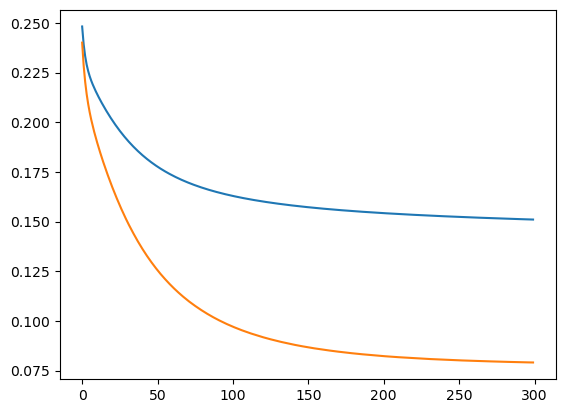

In [368]:
import pylab as pl
pl.plot(perceptron.train_errors, label='train')
pl.plot(perceptron.testing_errors, label='test')

# Uses Excel for experiment

### Data Training

In [181]:
train = pd.read_excel('/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/Data Training.xlsx', sheet_name='Hasil Encode', index_col=0)
x_train = train.iloc[:, 2:].values
y_train = train.iloc[:, 1].values
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2


In [310]:
train_normalize = pd.read_excel('/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/Data Training.xlsx', sheet_name='Normalisasi', index_col=0)
train_normalize.drop('PassengerId', axis=1, inplace=True)
x_train_normalize = train_normalize.iloc[:, 1:-1].values
y_train_normalize = train_normalize.iloc[:, -1].values
train_normalize.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1.0,1,0.271174,0.2,0.0,0.014151,1.0,0
1,0.0,0,0.472229,0.2,0.0,0.139136,0.0,1
2,1.0,0,0.321438,0.0,0.0,0.015469,1.0,1
3,0.0,0,0.434531,0.2,0.0,0.103644,1.0,1
4,1.0,1,0.434531,0.0,0.0,0.015713,1.0,0


### Data Testing

In [193]:
test = pd.read_excel('/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/Data Testing.xlsx', sheet_name='Hasil Encode', index_col=0)

label = pd.read_csv("/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/data/test_data_GroundTruth_cl.csv")

x_test = test.iloc[:, 1:].values
y_test = label['Survived'].values

test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,1
1,893,3,0,47.0,1,0,7.0000,2
2,894,2,1,62.0,0,0,9.6875,1
3,895,3,1,27.0,0,0,8.6625,2
4,896,3,0,22.0,1,1,12.2875,2


In [309]:
test_normalize = pd.read_excel('/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/Data Testing.xlsx', sheet_name='Normalisasi', index_col=0)
test_normalize.drop('PassengerId', axis=1, inplace=True)
x_test_normalize = test_normalize.iloc[:, 1:-1].values
y_test_normalize = test_normalize.iloc[:, -1].values
test_normalize.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1.0,1,0.452723,0.000,0.000000,0.015282,0.5,0
1,1.0,0,0.617566,0.125,0.000000,0.013663,1.0,1
2,0.5,1,0.815377,0.000,0.000000,0.018909,0.5,0
3,1.0,1,0.353818,0.000,0.000000,0.016908,1.0,0
4,1.0,0,0.287881,0.125,0.166667,0.023984,1.0,1


In [195]:
def plot_cm(matrix, title): 
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=sns.cubehelix_palette(as_cmap=True))

    ax.set_title(f'Confusion Matrix {title}', pad=10);
    ax.xaxis.set_ticklabels(['Not Survived', 'Survived']);ax.yaxis.set_ticklabels(['Not Survived', 'Survived'])
    plt.show()

In [316]:
lr = 0.01
epochs = 1000

In [201]:
optimizer = keras.optimizers.SGD(learning_rate=0.01)
keras.utils.set_random_seed(42)
model = keras.Sequential([keras.layers.Dense(units=1, input_shape=[len(x_train_normalize[0])], activation='sigmoid', kernel_initializer='random_uniform')])
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [202]:
weights = model.get_weights()
weights

[array([[ 0.03581891],
        [ 0.01626286],
        [-0.01412892],
        [ 0.04499895],
        [-0.04219389],
        [ 0.01523323]], dtype=float32),
 array([0.], dtype=float32)]

In [203]:
model.fit(x_train_normalize, y_train_normalize, epochs=epochs)

predict = model.predict(x_test_normalize)
predict = np.round(predict)
predict = predict.astype(int)
predict = predict.reshape(1, -1)[0]

Epoch 1/100
 1/23 [>.............................] - ETA: 10s - loss: 0.2577 - accuracy: 0.2812

2023-12-03 09:36:56.099308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 24ms/step - loss: 0.2531 - accuracy: 0.3174
Epoch 2/100
23/23 [==============================] - 0s 21ms/step - loss: 0.2495 - accuracy: 0.5449
Epoch 3/100
23/23 [==============================] - 1s 26ms/step - loss: 0.2466 - accuracy: 0.5941
Epoch 4/100
23/23 [==============================] - 0s 19ms/step - loss: 0.2439 - accuracy: 0.5955
Epoch 5/100
23/23 [==============================] - 0s 19ms/step - loss: 0.2414 - accuracy: 0.5955
Epoch 6/100
23/23 [==============================] - 0s 18ms/step - loss: 0.2392 - accuracy: 0.5955
Epoch 7/100
23/23 [==============================] - 0s 18ms/step - loss: 0.2372 - accuracy: 0.5955
Epoch 8/100
23/23 [==============================] - 0s 18ms/step - loss: 0.2354 - accuracy: 0.5955
Epoch 9/100
23/23 [==============================] - 0s 18ms/step - loss: 0.2337 - accuracy: 0.5955
Epoch 10/100
23/23 [==============================] - 1s 23ms/step - loss: 0.2323 - accuracy: 0.5955
Epoch 11/10

2023-12-03 09:37:43.365299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


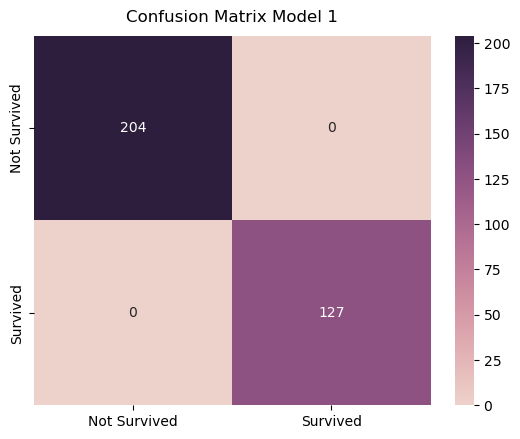

In [204]:
model1_cf1 = confusion_matrix(y_test_normalize, predict)
plot_cm(model1_cf1, 'Model 1')

In [205]:
model1_report = classification_report(y_test_normalize, predict, output_dict=True, target_names=['Not Survived',"Survived"])
pd.DataFrame(model1_report).transpose()

,precision,recall,f1-score,support
Not Survived,1.0,1.0,1.0,204.0
Survived,1.0,1.0,1.0,127.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,331.0
weighted avg,1.0,1.0,1.0,331.0


## Model Binary Step

In [317]:
class SingleLayerPerceptron:
    def __init__(self, input_size, learning_rate, epochs):
        np.random.seed(42)
        self.weights = np.random.uniform(-0.3,0.3, size=input_size+1)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def _activation_function(self, x):
        return 1 if x >= 0 else 0

    def _predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return self._activation_function(summation)

    def _calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy * 100

    def train(self, X_train, y_train):
        for epoch in range(self.epochs):
            for inputs, label in zip(X_train, y_train):
                prediction = self._predict(inputs)

                # Update weights
                error = label - prediction
                self.weights[1:] += self.learning_rate * error * inputs
                self.weights[0] += self.learning_rate * error

            # Calculate training accuracy at each epoch
            training_accuracy = self._calculate_accuracy(X_train, y_train)
            print(f"Epoch {epoch + 1}/{self.epochs}: Training Accuracy = {training_accuracy:.2f}%")

    def predict(self, X_test):
        predictions = [self._predict(inputs) for inputs in X_test]
        return np.array(predictions)
    
    def get_weights(self):
        return self.weights

In [318]:
input_size = x_train_normalize.shape[1]
perceptron = SingleLayerPerceptron(input_size, learning_rate=lr, epochs=epochs)
perceptron.train(x_train_normalize, y_train_normalize)
pred = perceptron.predict(x_test_normalize)

Epoch 1/1000: Training Accuracy = 69.94%
Epoch 2/1000: Training Accuracy = 78.65%
Epoch 3/1000: Training Accuracy = 72.19%
Epoch 4/1000: Training Accuracy = 77.67%
Epoch 5/1000: Training Accuracy = 77.25%
Epoch 6/1000: Training Accuracy = 77.39%
Epoch 7/1000: Training Accuracy = 77.53%
Epoch 8/1000: Training Accuracy = 75.42%
Epoch 9/1000: Training Accuracy = 62.78%
Epoch 10/1000: Training Accuracy = 55.06%
Epoch 11/1000: Training Accuracy = 77.39%
Epoch 12/1000: Training Accuracy = 74.58%
Epoch 13/1000: Training Accuracy = 77.25%
Epoch 14/1000: Training Accuracy = 77.67%
Epoch 15/1000: Training Accuracy = 78.09%
Epoch 16/1000: Training Accuracy = 77.95%
Epoch 17/1000: Training Accuracy = 72.19%
Epoch 18/1000: Training Accuracy = 77.81%
Epoch 19/1000: Training Accuracy = 61.38%
Epoch 20/1000: Training Accuracy = 77.67%
Epoch 21/1000: Training Accuracy = 71.63%
Epoch 22/1000: Training Accuracy = 78.09%
Epoch 23/1000: Training Accuracy = 77.53%
Epoch 24/1000: Training Accuracy = 65.03%
E

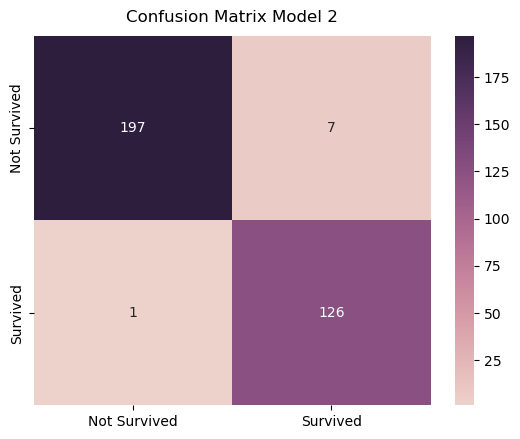

In [319]:
model2_cf = confusion_matrix(y_test_normalize, pred)
plot_cm(model2_cf, 'Model 2')

In [320]:
model2_report = classification_report(y_test_normalize, pred, output_dict=True, target_names=['Not Survived',"Survived"])
pd.DataFrame(model2_report).transpose()

,precision,recall,f1-score,support
Not Survived,0.994949,0.965686,0.980100,204.000000
Survived,0.947368,0.992126,0.969231,127.000000
accuracy,0.975831,0.975831,0.975831,0.975831
macro avg,0.971159,0.978906,0.974665,331.000000
weighted avg,0.976693,0.975831,0.975929,331.000000


## Experiment Epoch

### Epoch 100

In [328]:
lr = 0.01
epochs = 100

In [329]:
class SingleLayerPerceptron:
    def __init__(self, input_size, learning_rate, epochs):
        np.random.seed(42)
        self.weights = np.random.uniform(-0.3,0.3, size=input_size+1)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def _activation_function(self, x):
        return 1 if x >= 0 else 0

    def _predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return self._activation_function(summation)

    def _calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy * 100

    def train(self, X_train, y_train):
        for epoch in range(self.epochs):
            for inputs, label in zip(X_train, y_train):
                prediction = self._predict(inputs)

                # Update weights
                error = label - prediction
                self.weights[1:] += self.learning_rate * error * inputs
                self.weights[0] += self.learning_rate * error

            # Calculate training accuracy at each epoch
            training_accuracy = self._calculate_accuracy(X_train, y_train)
            print(f"Epoch {epoch + 1}/{self.epochs}: Training Accuracy = {training_accuracy:.2f}%")

    def predict(self, X_test):
        predictions = [self._predict(inputs) for inputs in X_test]
        return np.array(predictions)
    
    def get_weights(self):
        return self.weights

In [330]:
input_size = x_train_normalize.shape[1]
perceptron = SingleLayerPerceptron(input_size, learning_rate=lr, epochs=epochs)
perceptron.train(x_train_normalize, y_train_normalize)
pred = perceptron.predict(x_test_normalize)

Epoch 1/100: Training Accuracy = 69.94%
Epoch 2/100: Training Accuracy = 78.65%
Epoch 3/100: Training Accuracy = 72.19%
Epoch 4/100: Training Accuracy = 77.67%
Epoch 5/100: Training Accuracy = 77.25%
Epoch 6/100: Training Accuracy = 77.39%
Epoch 7/100: Training Accuracy = 77.53%
Epoch 8/100: Training Accuracy = 75.42%
Epoch 9/100: Training Accuracy = 62.78%
Epoch 10/100: Training Accuracy = 55.06%
Epoch 11/100: Training Accuracy = 77.39%
Epoch 12/100: Training Accuracy = 74.58%
Epoch 13/100: Training Accuracy = 77.25%
Epoch 14/100: Training Accuracy = 77.67%
Epoch 15/100: Training Accuracy = 78.09%
Epoch 16/100: Training Accuracy = 77.95%
Epoch 17/100: Training Accuracy = 72.19%
Epoch 18/100: Training Accuracy = 77.81%
Epoch 19/100: Training Accuracy = 61.38%
Epoch 20/100: Training Accuracy = 77.67%
Epoch 21/100: Training Accuracy = 71.63%
Epoch 22/100: Training Accuracy = 78.09%
Epoch 23/100: Training Accuracy = 77.53%
Epoch 24/100: Training Accuracy = 65.03%
Epoch 25/100: Training Ac

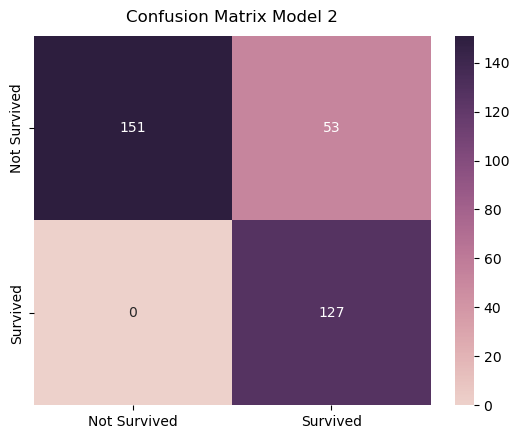

In [331]:
model2_cf = confusion_matrix(y_test_normalize, pred)
plot_cm(model2_cf, 'Model 2')

In [332]:
model2_report = classification_report(y_test_normalize, pred, output_dict=True, target_names=['Not Survived',"Survived"])
pd.DataFrame(model2_report).transpose()

,precision,recall,f1-score,support
Not Survived,1.000000,0.740196,0.850704,204.000000
Survived,0.705556,1.000000,0.827362,127.000000
accuracy,0.839879,0.839879,0.839879,0.839879
macro avg,0.852778,0.870098,0.839033,331.000000
weighted avg,0.887026,0.839879,0.841748,331.000000


### Epoch 500

In [333]:
lr = 0.01
epochs = 500

In [334]:
class SingleLayerPerceptron:
    def __init__(self, input_size, learning_rate, epochs):
        np.random.seed(42)
        self.weights = np.random.uniform(-0.3,0.3, size=input_size+1)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def _activation_function(self, x):
        return 1 if x >= 0 else 0

    def _predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return self._activation_function(summation)

    def _calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy * 100

    def train(self, X_train, y_train):
        for epoch in range(self.epochs):
            for inputs, label in zip(X_train, y_train):
                prediction = self._predict(inputs)

                # Update weights
                error = label - prediction
                self.weights[1:] += self.learning_rate * error * inputs
                self.weights[0] += self.learning_rate * error

            # Calculate training accuracy at each epoch
            training_accuracy = self._calculate_accuracy(X_train, y_train)
            print(f"Epoch {epoch + 1}/{self.epochs}: Training Accuracy = {training_accuracy:.2f}%")

    def predict(self, X_test):
        predictions = [self._predict(inputs) for inputs in X_test]
        return np.array(predictions)
    
    def get_weights(self):
        return self.weights

In [336]:
input_size = x_train_normalize.shape[1]
perceptron = SingleLayerPerceptron(input_size, learning_rate=lr, epochs=epochs)
perceptron.train(x_train_normalize, y_train_normalize)
pred = perceptron.predict(x_test_normalize)

Epoch 1/500: Training Accuracy = 69.94%
Epoch 2/500: Training Accuracy = 78.65%
Epoch 3/500: Training Accuracy = 72.19%
Epoch 4/500: Training Accuracy = 77.67%
Epoch 5/500: Training Accuracy = 77.25%
Epoch 6/500: Training Accuracy = 77.39%
Epoch 7/500: Training Accuracy = 77.53%
Epoch 8/500: Training Accuracy = 75.42%
Epoch 9/500: Training Accuracy = 62.78%
Epoch 10/500: Training Accuracy = 55.06%
Epoch 11/500: Training Accuracy = 77.39%
Epoch 12/500: Training Accuracy = 74.58%
Epoch 13/500: Training Accuracy = 77.25%
Epoch 14/500: Training Accuracy = 77.67%
Epoch 15/500: Training Accuracy = 78.09%
Epoch 16/500: Training Accuracy = 77.95%
Epoch 17/500: Training Accuracy = 72.19%
Epoch 18/500: Training Accuracy = 77.81%
Epoch 19/500: Training Accuracy = 61.38%
Epoch 20/500: Training Accuracy = 77.67%
Epoch 21/500: Training Accuracy = 71.63%
Epoch 22/500: Training Accuracy = 78.09%
Epoch 23/500: Training Accuracy = 77.53%
Epoch 24/500: Training Accuracy = 65.03%
Epoch 25/500: Training Ac

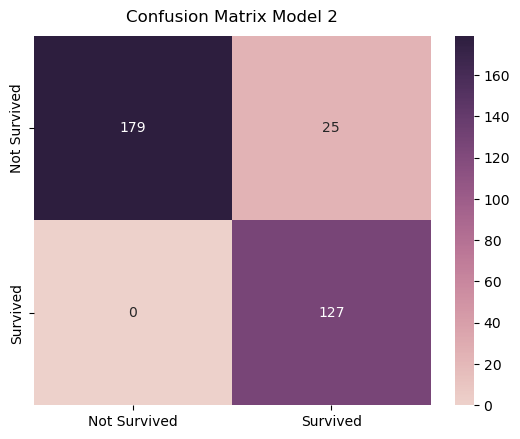

In [337]:
model2_cf = confusion_matrix(y_test_normalize, pred)
plot_cm(model2_cf, 'Model 2')

In [338]:
model2_report = classification_report(y_test_normalize, pred, output_dict=True, target_names=['Not Survived',"Survived"])
pd.DataFrame(model2_report).transpose()

,precision,recall,f1-score,support
Not Survived,1.000000,0.877451,0.934726,204.000000
Survived,0.835526,1.000000,0.910394,127.000000
accuracy,0.924471,0.924471,0.924471,0.924471
macro avg,0.917763,0.938725,0.922560,331.000000
weighted avg,0.936894,0.924471,0.925390,331.000000


### Epoch 700

In [339]:
lr = 0.01
epochs = 700

In [340]:
class SingleLayerPerceptron:
    def __init__(self, input_size, learning_rate, epochs):
        np.random.seed(42)
        self.weights = np.random.uniform(-0.3,0.3, size=input_size+1)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def _activation_function(self, x):
        return 1 if x >= 0 else 0

    def _predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return self._activation_function(summation)

    def _calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy * 100

    def train(self, X_train, y_train):
        for epoch in range(self.epochs):
            for inputs, label in zip(X_train, y_train):
                prediction = self._predict(inputs)

                # Update weights
                error = label - prediction
                self.weights[1:] += self.learning_rate * error * inputs
                self.weights[0] += self.learning_rate * error

            # Calculate training accuracy at each epoch
            training_accuracy = self._calculate_accuracy(X_train, y_train)
            print(f"Epoch {epoch + 1}/{self.epochs}: Training Accuracy = {training_accuracy:.2f}%")

    def predict(self, X_test):
        predictions = [self._predict(inputs) for inputs in X_test]
        return np.array(predictions)
    
    def get_weights(self):
        return self.weights

In [341]:
input_size = x_train_normalize.shape[1]
perceptron = SingleLayerPerceptron(input_size, learning_rate=lr, epochs=epochs)
perceptron.train(x_train_normalize, y_train_normalize)
pred = perceptron.predict(x_test_normalize)

Epoch 1/700: Training Accuracy = 69.94%
Epoch 2/700: Training Accuracy = 78.65%
Epoch 3/700: Training Accuracy = 72.19%
Epoch 4/700: Training Accuracy = 77.67%
Epoch 5/700: Training Accuracy = 77.25%
Epoch 6/700: Training Accuracy = 77.39%
Epoch 7/700: Training Accuracy = 77.53%
Epoch 8/700: Training Accuracy = 75.42%
Epoch 9/700: Training Accuracy = 62.78%
Epoch 10/700: Training Accuracy = 55.06%
Epoch 11/700: Training Accuracy = 77.39%
Epoch 12/700: Training Accuracy = 74.58%
Epoch 13/700: Training Accuracy = 77.25%
Epoch 14/700: Training Accuracy = 77.67%
Epoch 15/700: Training Accuracy = 78.09%
Epoch 16/700: Training Accuracy = 77.95%
Epoch 17/700: Training Accuracy = 72.19%
Epoch 18/700: Training Accuracy = 77.81%
Epoch 19/700: Training Accuracy = 61.38%
Epoch 20/700: Training Accuracy = 77.67%
Epoch 21/700: Training Accuracy = 71.63%
Epoch 22/700: Training Accuracy = 78.09%
Epoch 23/700: Training Accuracy = 77.53%
Epoch 24/700: Training Accuracy = 65.03%
Epoch 25/700: Training Ac

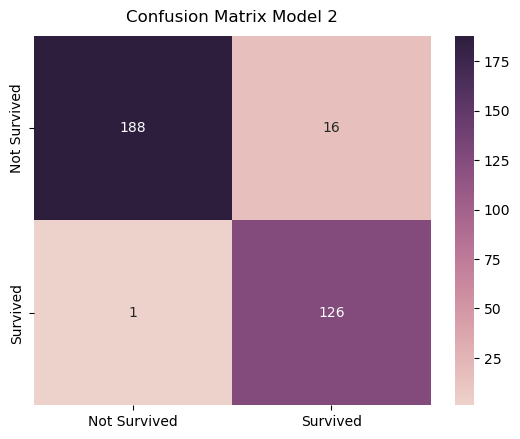

In [342]:
model2_cf = confusion_matrix(y_test_normalize, pred)
plot_cm(model2_cf, 'Model 2')

In [343]:
model2_report = classification_report(y_test_normalize, pred, output_dict=True, target_names=['Not Survived',"Survived"])
pd.DataFrame(model2_report).transpose()

,precision,recall,f1-score,support
Not Survived,0.994709,0.921569,0.956743,204.00000
Survived,0.887324,0.992126,0.936803,127.00000
accuracy,0.948640,0.948640,0.948640,0.94864
macro avg,0.941016,0.956847,0.946773,331.00000
weighted avg,0.953507,0.948640,0.949092,331.00000


### Epoch 1000

In [322]:
lr = 0.01
epochs = 1000

In [323]:
class SingleLayerPerceptron:
    def __init__(self, input_size, learning_rate, epochs):
        np.random.seed(42)
        self.weights = np.random.uniform(-0.3,0.3, size=input_size+1)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def _activation_function(self, x):
        return 1 if x >= 0 else 0

    def _predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return self._activation_function(summation)

    def _calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy * 100

    def train(self, X_train, y_train):
        for epoch in range(self.epochs):
            for inputs, label in zip(X_train, y_train):
                prediction = self._predict(inputs)

                # Update weights
                error = label - prediction
                self.weights[1:] += self.learning_rate * error * inputs
                self.weights[0] += self.learning_rate * error

            # Calculate training accuracy at each epoch
            training_accuracy = self._calculate_accuracy(X_train, y_train)
            print(f"Epoch {epoch + 1}/{self.epochs}: Training Accuracy = {training_accuracy:.2f}%")

    def predict(self, X_test):
        predictions = [self._predict(inputs) for inputs in X_test]
        return np.array(predictions)
    
    def get_weights(self):
        return self.weights

In [325]:
input_size = x_train_normalize.shape[1]
perceptron = SingleLayerPerceptron(input_size, learning_rate=lr, epochs=epochs)
perceptron.train(x_train_normalize, y_train_normalize)
pred = perceptron.predict(x_test_normalize)

Epoch 1/1000: Training Accuracy = 69.94%
Epoch 2/1000: Training Accuracy = 78.65%
Epoch 3/1000: Training Accuracy = 72.19%
Epoch 4/1000: Training Accuracy = 77.67%
Epoch 5/1000: Training Accuracy = 77.25%
Epoch 6/1000: Training Accuracy = 77.39%
Epoch 7/1000: Training Accuracy = 77.53%
Epoch 8/1000: Training Accuracy = 75.42%
Epoch 9/1000: Training Accuracy = 62.78%
Epoch 10/1000: Training Accuracy = 55.06%
Epoch 11/1000: Training Accuracy = 77.39%
Epoch 12/1000: Training Accuracy = 74.58%
Epoch 13/1000: Training Accuracy = 77.25%
Epoch 14/1000: Training Accuracy = 77.67%
Epoch 15/1000: Training Accuracy = 78.09%
Epoch 16/1000: Training Accuracy = 77.95%
Epoch 17/1000: Training Accuracy = 72.19%
Epoch 18/1000: Training Accuracy = 77.81%
Epoch 19/1000: Training Accuracy = 61.38%
Epoch 20/1000: Training Accuracy = 77.67%
Epoch 21/1000: Training Accuracy = 71.63%
Epoch 22/1000: Training Accuracy = 78.09%
Epoch 23/1000: Training Accuracy = 77.53%
Epoch 24/1000: Training Accuracy = 65.03%
E

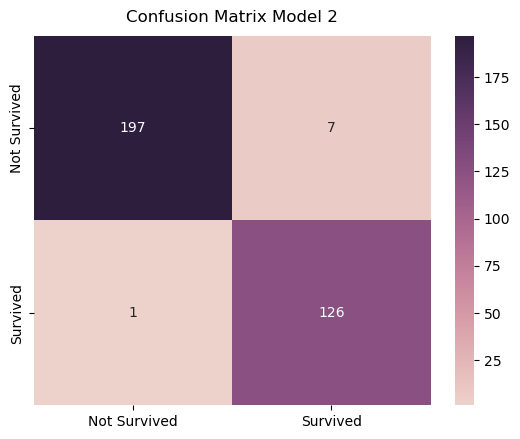

In [326]:
model2_cf = confusion_matrix(y_test_normalize, pred)
plot_cm(model2_cf, 'Model 2')

In [327]:
model2_report = classification_report(y_test_normalize, pred, output_dict=True, target_names=['Not Survived',"Survived"])
pd.DataFrame(model2_report).transpose()

,precision,recall,f1-score,support
Not Survived,0.994949,0.965686,0.980100,204.000000
Survived,0.947368,0.992126,0.969231,127.000000
accuracy,0.975831,0.975831,0.975831,0.975831
macro avg,0.971159,0.978906,0.974665,331.000000
weighted avg,0.976693,0.975831,0.975929,331.000000


### Epoch 1200

In [369]:
lr = 0.01
epochs = 1200

In [370]:
class SingleLayerPerceptron:
    def __init__(self, input_size, learning_rate, epochs):
        np.random.seed(42)
        self.weights = np.random.uniform(-0.3,0.3, size=input_size+1)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def _activation_function(self, x):
        return 1 if x >= 0 else 0

    def _predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return self._activation_function(summation)

    def _calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy * 100

    def train(self, X_train, y_train):
        for epoch in range(self.epochs):
            for inputs, label in zip(X_train, y_train):
                prediction = self._predict(inputs)

                # Update weights
                error = label - prediction
                self.weights[1:] += self.learning_rate * error * inputs
                self.weights[0] += self.learning_rate * error

            # Calculate training accuracy at each epoch
            training_accuracy = self._calculate_accuracy(X_train, y_train)
            print(f"Epoch {epoch + 1}/{self.epochs}: Training Accuracy = {training_accuracy:.2f}%")

    def predict(self, X_test):
        predictions = [self._predict(inputs) for inputs in X_test]
        return np.array(predictions)
    
    def get_weights(self):
        return self.weights

In [371]:
input_size = x_train_normalize.shape[1]
perceptron = SingleLayerPerceptron(input_size, learning_rate=lr, epochs=epochs)
perceptron.train(x_train_normalize, y_train_normalize)
pred = perceptron.predict(x_test_normalize)

Epoch 1/1200: Training Accuracy = 69.94%
Epoch 2/1200: Training Accuracy = 78.65%
Epoch 3/1200: Training Accuracy = 72.19%
Epoch 4/1200: Training Accuracy = 77.67%
Epoch 5/1200: Training Accuracy = 77.25%
Epoch 6/1200: Training Accuracy = 77.39%
Epoch 7/1200: Training Accuracy = 77.53%
Epoch 8/1200: Training Accuracy = 75.42%
Epoch 9/1200: Training Accuracy = 62.78%
Epoch 10/1200: Training Accuracy = 55.06%
Epoch 11/1200: Training Accuracy = 77.39%
Epoch 12/1200: Training Accuracy = 74.58%
Epoch 13/1200: Training Accuracy = 77.25%
Epoch 14/1200: Training Accuracy = 77.67%
Epoch 15/1200: Training Accuracy = 78.09%
Epoch 16/1200: Training Accuracy = 77.95%
Epoch 17/1200: Training Accuracy = 72.19%
Epoch 18/1200: Training Accuracy = 77.81%
Epoch 19/1200: Training Accuracy = 61.38%
Epoch 20/1200: Training Accuracy = 77.67%
Epoch 21/1200: Training Accuracy = 71.63%
Epoch 22/1200: Training Accuracy = 78.09%
Epoch 23/1200: Training Accuracy = 77.53%
Epoch 24/1200: Training Accuracy = 65.03%
E

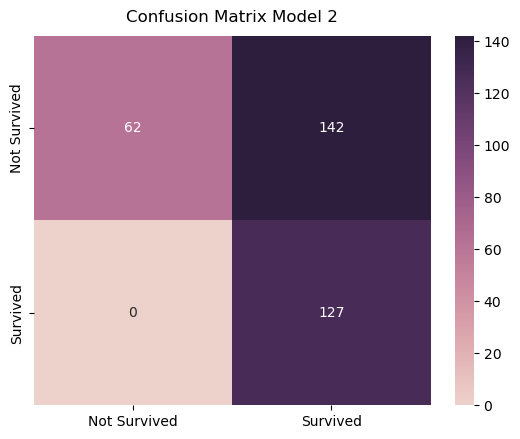

In [372]:
model2_cf = confusion_matrix(y_test_normalize, pred)
plot_cm(model2_cf, 'Model 2')

In [373]:
model2_report = classification_report(y_test_normalize, pred, output_dict=True, target_names=['Not Survived',"Survived"])
pd.DataFrame(model2_report).transpose()

,precision,recall,f1-score,support
Not Survived,1.000000,0.303922,0.466165,204.000000
Survived,0.472119,1.000000,0.641414,127.000000
accuracy,0.570997,0.570997,0.570997,0.570997
macro avg,0.736059,0.651961,0.553790,331.000000
weighted avg,0.797460,0.570997,0.533406,331.000000
